In [241]:
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import shapiro, levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

In [242]:
# Similar to the parsefile.py, we parse the results files:

def parse_file(file_path):
    with open(file_path, 'r', encoding="utf-8") as f:
        content = f.read()

    blocks = re.split(r"Performance counter stats for 'system wide':", content)
    rows = []

    def clean_float(s):
        return float(s.replace('\u202F', '').replace(' ', '').replace(',', '.'))

    def clean_int(s):
        return int(s.replace('\u202F', '').replace(' ', ''))

    for block in blocks[1:]:
        pkg_match = re.search(r"([\d,]+) Joules power/energy-pkg/", block)
        core_match = re.search(r"([\d,]+) Joules power/energy-cores/", block)
        cycles_match = re.search(r"([\d\s\u202F]+) +cycles", block)
        instr_match = re.search(r"([\d\s\u202F]+) +instructions", block)
        cache_ref_match = re.search(r"([\d\s\u202F]+) +cache-references", block)
        cache_miss_match = re.search(r"([\d\s\u202F]+) +cache-misses", block)
        cs_match = re.search(r"([\d\s\u202F]+) +cs", block)
        migrations_match = re.search(r"([\d\s\u202F]+) +migrations", block)
        pf_match = re.search(r"([\d\s\u202F]+) +page-faults", block)

        data = {
            "energy_pkg": clean_float(pkg_match.group(1)),
            "energy_cores": clean_float(core_match.group(1)),
            "cycles": clean_int(cycles_match.group(1)),
            "instructions": clean_int(instr_match.group(1)),
            "cache_references": clean_int(cache_ref_match.group(1)),
            "cache_misses": clean_int(cache_miss_match.group(1)),
            "cs": clean_int(cs_match.group(1)),
            "migrations": clean_int(migrations_match.group(1)),
            "page_faults": clean_int(pf_match.group(1)),
        }
        rows.append(data)

    return rows


In [243]:
all_rows = []

# Create dataframe 

test_file_names = [
    "test_leo_skeleton_base_empty.txt",
    "test_leo_skeleton_base_long.txt",
    "test_leo_skeleton_base_medium.txt",
    "test_leo_skeleton_change_empty.txt",
    "test_leo_skeleton_change_long.txt", 
    "test_leo_skeleton_change_medium.txt", 
    "test_leo_skeleton_change+logging_long.txt",
    "test_leo_skeleton_change+logging_medium.txt",
    "test_leo_skeleton_change+logging_empty.txt",
    "test_mu_skeleton_base_empty.txt",
    "test_mu_skeleton_base_long.txt",
    "test_mu_skeleton_base_medium.txt",
    "test_mu_skeleton_change_empty.txt",
    "test_mu_skeleton_change_long.txt",
    "test_mu_skeleton_change_medium.txt",
    "test_mu_skeleton_change+logging_long.txt",
    "test_mu_skeleton_change+logging_medium.txt",
    "test_mu_skeleton_change+logging_empty.txt",
    "test_novelWriter_skeleton_base_empty.txt",
    "test_novelWriter_skeleton_base_long.txt",
    "test_novelWriter_skeleton_base_medium.txt",
    "test_novelWriter_skeleton_change_empty.txt",
    "test_novelWriter_skeleton_change_long.txt",
    "test_novelWriter_skeleton_change_medium.txt",
    "test_novelWriter_skeleton_change+logging_long.txt",
    "test_novelWriter_skeleton_change+logging_medium.txt",
    "test_novelWriter_skeleton_change+logging_empty.txt"
]
for file in test_file_names:
    parsed = parse_file(file)
    test_name = os.path.basename(file).replace(".txt","")
    for idx, row in enumerate(parsed,1):
        row["test"] = test_name
        row["run"] = idx
        all_rows.append(row)
test_df = pd.DataFrame(all_rows)

# Add new columns for app, variant and size grouping
test_df[['app', 'variant', 'size']] = (
    test_df['test'].str.extract(r'test_(?P<app>[a-zA-Z]+)_skeleton_(?P<variant>[^_]+)_(?P<size>empty|medium|long)')
)

print(test_df.head(10))

   energy_pkg  energy_cores      cycles  instructions  cache_references  \
0       58.15          2.62  1205632822     420613620          47533145   
1       45.54          2.41  1172328882     358697847          44816818   
2       53.22          2.33  1145813786     363630064          44353035   
3       56.20          2.78  1288981070     374030561          47821323   
4       61.27          2.63  1296263687     541997216          47250695   
5       62.07          2.42  1166862379     360993520          45594577   
6       55.56          2.36  1164006373     352163462          44268202   
7       58.49          2.41  1240766886     434766567          45593474   
8       55.31          2.80  1303753001     554700304          46004282   
9       56.28          2.50  1195266861     373586452          45852171   

   cache_misses     cs  migrations  page_faults                          test  \
0      23117788  11333          66         1120  test_leo_skeleton_base_empty   
1      22199

In [244]:
all_rows = []

# Create dataframe 

control_file_names = [
    "control_test_empty.txt",
    "control_test_medium.txt",
    "control_test_long.txt"
]
for file in control_file_names:
    parsed = parse_file(file)
    test_name = os.path.basename(file).replace(".txt","")
    for idx, row in enumerate(parsed,1):
        row["test"] = test_name
        row["run"] = idx
        all_rows.append(row)
control_df = pd.DataFrame(all_rows)


control_df["size"] = control_df["test"].str.extract(r'_(empty|medium|long)$', expand=False)


metrics = [c for c in control_df.columns
           if c not in ("test", "run", "size")]

control_means = control_df.groupby("size")[metrics].mean()

print(control_means)

        energy_pkg  energy_cores        cycles  instructions  \
size                                                           
empty    47.767333      2.562333  1.269681e+09  5.427776e+08   
long     46.542000      2.496667  1.320230e+09  6.582885e+08   
medium   50.271333      2.463333  1.290682e+09  6.136461e+08   

        cache_references  cache_misses            cs  migrations  page_faults  
size                                                                           
empty       4.347704e+07  2.133112e+07  10242.400000   70.233333  1274.366667  
long        4.613583e+07  2.259630e+07  11438.766667  239.866667  2100.533333  
medium      4.516284e+07  2.231002e+07  11495.300000  234.333333  1507.000000  


<Figure size 640x480 with 0 Axes>

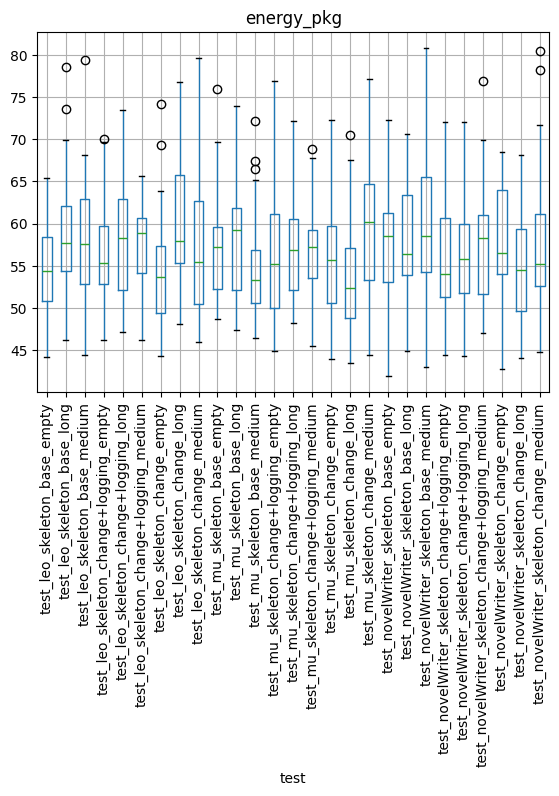

In [245]:
import matplotlib.pyplot as plt

plt.figure()
test_df.boxplot(column="energy_pkg", by="test", rot=90)
plt.title(col)
plt.suptitle("")
plt.show()

In [246]:
# Subtract control from each test
for m in metrics:
    test_df[m] -= test_df["size"].map(control_means[m])

test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.382667,0.057667,-6.404795e+07,-1.221639e+08,4.056103e+06,1786670.6,1090.6,-4.233333,-154.366667,test_leo_skeleton_base_empty,1,leo,base,empty
1,-2.227333,-0.152333,-9.735189e+07,-1.840797e+08,1.339776e+06,868690.6,810.6,-22.233333,-1073.366667,test_leo_skeleton_base_empty,2,leo,base,empty
2,5.452667,-0.232333,-1.238670e+08,-1.791475e+08,8.759928e+05,845492.6,685.6,1.766667,-401.366667,test_leo_skeleton_base_empty,3,leo,base,empty
3,8.432667,0.217667,1.930030e+07,-1.687470e+08,4.344281e+06,2226613.6,1283.6,-8.233333,-1098.366667,test_leo_skeleton_base_empty,4,leo,base,empty
4,13.502667,0.067667,2.658292e+07,-7.803483e+05,3.773653e+06,1537451.6,1333.6,15.766667,1043.633333,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,12.672667,-0.112333,-1.128239e+08,-1.770337e+08,1.409166e+06,856383.6,789.6,-0.233333,-1034.366667,test_novelWriter_skeleton_change+logging_empty,26,novelWriter,change+logging,empty
806,19.142667,0.107667,-1.401408e+08,-1.954753e+08,9.695078e+05,709814.6,518.6,-16.233333,-487.366667,test_novelWriter_skeleton_change+logging_empty,27,novelWriter,change+logging,empty
807,6.012667,0.197667,3.984015e+07,-2.507989e+06,2.973705e+06,1819314.6,1070.6,23.766667,913.633333,test_novelWriter_skeleton_change+logging_empty,28,novelWriter,change+logging,empty
808,6.332667,-0.112333,-9.368674e+07,-2.088555e+08,3.761258e+05,952492.6,641.6,10.766667,-1186.366667,test_novelWriter_skeleton_change+logging_empty,29,novelWriter,change+logging,empty


In [247]:
# Test for normality - Shapiro-Wilk test

shapiro_results = []
for name, grp in test_df.groupby("test"):
    stat, p = shapiro(grp["energy_pkg"])
    shapiro_results.append({"test": name, "stat": stat, "p": p})
norm_df = pd.DataFrame(shapiro_results)

# Stat = values closer to 1 indicate normality
# p = probability of observing stat as extreme as you did 
# p <= 0.05 (most commonly), we can reject null and conclude this sample significantly deviates from normal
# p > 0.05, we don't have evidence the data isn't normal

print(norm_df)

alpha = 0.05

norm_df['is_normal'] = norm_df['p'] > alpha

normal_tests = norm_df[norm_df['is_normal']]['test'].tolist()
print("Test cases that are normally distributed (p > 0.05):")
for t in normal_tests:
    print(f"- {t}")

                                               test      stat         p
0                      test_leo_skeleton_base_empty  0.979687  0.817173
1                       test_leo_skeleton_base_long  0.960833  0.325288
2                     test_leo_skeleton_base_medium  0.970981  0.566355
3            test_leo_skeleton_change+logging_empty  0.952592  0.198269
4             test_leo_skeleton_change+logging_long  0.955131  0.231478
5           test_leo_skeleton_change+logging_medium  0.945234  0.125869
6                    test_leo_skeleton_change_empty  0.909404  0.014375
7                     test_leo_skeleton_change_long  0.954016  0.216294
8                   test_leo_skeleton_change_medium  0.926824  0.040461
9                       test_mu_skeleton_base_empty  0.898541  0.007737
10                       test_mu_skeleton_base_long  0.948513  0.154226
11                     test_mu_skeleton_base_medium  0.886869  0.004070
12            test_mu_skeleton_change+logging_empty  0.955932  0

In [248]:
test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.382667,0.057667,-6.404795e+07,-1.221639e+08,4.056103e+06,1786670.6,1090.6,-4.233333,-154.366667,test_leo_skeleton_base_empty,1,leo,base,empty
1,-2.227333,-0.152333,-9.735189e+07,-1.840797e+08,1.339776e+06,868690.6,810.6,-22.233333,-1073.366667,test_leo_skeleton_base_empty,2,leo,base,empty
2,5.452667,-0.232333,-1.238670e+08,-1.791475e+08,8.759928e+05,845492.6,685.6,1.766667,-401.366667,test_leo_skeleton_base_empty,3,leo,base,empty
3,8.432667,0.217667,1.930030e+07,-1.687470e+08,4.344281e+06,2226613.6,1283.6,-8.233333,-1098.366667,test_leo_skeleton_base_empty,4,leo,base,empty
4,13.502667,0.067667,2.658292e+07,-7.803483e+05,3.773653e+06,1537451.6,1333.6,15.766667,1043.633333,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,12.672667,-0.112333,-1.128239e+08,-1.770337e+08,1.409166e+06,856383.6,789.6,-0.233333,-1034.366667,test_novelWriter_skeleton_change+logging_empty,26,novelWriter,change+logging,empty
806,19.142667,0.107667,-1.401408e+08,-1.954753e+08,9.695078e+05,709814.6,518.6,-16.233333,-487.366667,test_novelWriter_skeleton_change+logging_empty,27,novelWriter,change+logging,empty
807,6.012667,0.197667,3.984015e+07,-2.507989e+06,2.973705e+06,1819314.6,1070.6,23.766667,913.633333,test_novelWriter_skeleton_change+logging_empty,28,novelWriter,change+logging,empty
808,6.332667,-0.112333,-9.368674e+07,-2.088555e+08,3.761258e+05,952492.6,641.6,10.766667,-1186.366667,test_novelWriter_skeleton_change+logging_empty,29,novelWriter,change+logging,empty


In [249]:
# in-app comparison
# using delta of base test - control test
# repeat this for each application and file size
# repeat for different measured things (e.g. instructions or other energy cores)

# chatGPT was used as an assistant to find general implementations of the statistical tests, which were then implemented by myself below

alpha = 0.05

groups_in_app = {
    "base": test_df.loc[test_df["test"]=="test_mu_skeleton_base_long","energy_pkg"].values,
    "change": test_df.loc[test_df["test"]=="test_mu_skeleton_change_long","energy_pkg"].values,
    "change+logging": test_df.loc[test_df["test"]=="test_mu_skeleton_change+logging_long","energy_pkg"].values
}

print("Normality per scenario:")
normality = []
for v, data in groups_in_app.items():
    W, p = shapiro(data)
    if p>alpha:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- normal")
    else:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- non-normal")

print("\nVariance:")
stat_levene, p_levene = levene(*groups_in_app.values())
if p_levene>alpha:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- equal variance")
else:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- unequal variance")

all_data = np.concatenate(list(groups_in_app.values()))

# chatGPT generated the line below
all_labels = np.repeat(list(groups_in_app.keys()), [len(g) for g in groups_in_app.values()])

# If all groups are normally distributed (shapiro-wilk), and has equal variances (levene)
if all(shapiro(g)[1] > alpha for g in groups_in_app.values()) and p_levene > alpha:
    # Data is parametric
    # Then we can do one way ANOVA
    F, p_main = f_oneway(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    #F, p_main = f_oneway(groups_in_app['leo'], groups_in_app['mu'], groups_in_app['nw'])
    if p_main>alpha:
        print("\nANOVA: F=", F, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nANOVA: F=", F, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Tukey HSD
    tukey = pairwise_tukeyhsd(endog=all_data, groups=all_labels, alpha=alpha)
    print("\nTukey HSD results:")
    print(tukey)
else:
    # Data is non-parametric
    # We can do Kruskal-Wallis
    H, p_main = kruskal(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    #H, p_main = kruskal(groups_in_app['leo'], groups_in_app['mu'], groups_in_app['nw'])
    if p_main>alpha:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Dunn-Bonferroni
    df_ph = pd.DataFrame({
        "value": all_data,
        "group": all_labels
    })

    dunn_res = sp.posthoc_dunn(df_ph, val_col='value', group_col='group', p_adjust='bonferroni')

    print("\nDunn-Bonferroni pairwise p-values:")
    print(dunn_res)



Normality per scenario:
base : W= 0.949 p= 0.154 - normal
change : W= 0.952 p= 0.187 - normal
change+logging : W= 0.962 p= 0.355 - normal

Variance:
Levene’s test: W= 1.1260380914458907 , p= 0.32899571700341 - equal variance

ANOVA: F= 4.2528444951527655 , p= 0.017290814932853733 - statistically significant difference

Tukey HSD results:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1     group2     meandiff p-adj   lower   upper  reject
------------------------------------------------------------
  base         change   -5.035 0.0132 -9.1823 -0.8877   True
  base change+logging  -1.9843 0.4917 -6.1316  2.1629  False
change change+logging   3.0507 0.1913 -1.0966  7.1979  False
------------------------------------------------------------


In [266]:
test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.382667,0.057667,-6.404795e+07,-1.221639e+08,4.056103e+06,1786670.6,1090.6,-4.233333,-154.366667,test_leo_skeleton_base_empty,1,leo,base,empty
1,-2.227333,-0.152333,-9.735189e+07,-1.840797e+08,1.339776e+06,868690.6,810.6,-22.233333,-1073.366667,test_leo_skeleton_base_empty,2,leo,base,empty
2,5.452667,-0.232333,-1.238670e+08,-1.791475e+08,8.759928e+05,845492.6,685.6,1.766667,-401.366667,test_leo_skeleton_base_empty,3,leo,base,empty
3,8.432667,0.217667,1.930030e+07,-1.687470e+08,4.344281e+06,2226613.6,1283.6,-8.233333,-1098.366667,test_leo_skeleton_base_empty,4,leo,base,empty
4,13.502667,0.067667,2.658292e+07,-7.803483e+05,3.773653e+06,1537451.6,1333.6,15.766667,1043.633333,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,12.672667,-0.112333,-1.128239e+08,-1.770337e+08,1.409166e+06,856383.6,789.6,-0.233333,-1034.366667,test_novelWriter_skeleton_change+logging_empty,26,novelWriter,change+logging,empty
806,19.142667,0.107667,-1.401408e+08,-1.954753e+08,9.695078e+05,709814.6,518.6,-16.233333,-487.366667,test_novelWriter_skeleton_change+logging_empty,27,novelWriter,change+logging,empty
807,6.012667,0.197667,3.984015e+07,-2.507989e+06,2.973705e+06,1819314.6,1070.6,23.766667,913.633333,test_novelWriter_skeleton_change+logging_empty,28,novelWriter,change+logging,empty
808,6.332667,-0.112333,-9.368674e+07,-2.088555e+08,3.761258e+05,952492.6,641.6,10.766667,-1186.366667,test_novelWriter_skeleton_change+logging_empty,29,novelWriter,change+logging,empty


In [267]:
test_df.groupby("test")["energy_pkg"].mean()

test
test_leo_skeleton_base_empty                        6.877667
test_leo_skeleton_base_long                        12.403333
test_leo_skeleton_base_medium                       8.073333
test_leo_skeleton_change+logging_empty              8.667333
test_leo_skeleton_change+logging_long              11.073667
test_leo_skeleton_change+logging_medium             6.954333
test_leo_skeleton_change_empty                      6.501667
test_leo_skeleton_change_long                      13.403333
test_leo_skeleton_change_medium                     6.944000
test_mu_skeleton_base_empty                         9.091667
test_mu_skeleton_base_long                         12.281333
test_mu_skeleton_base_medium                        4.820000
test_mu_skeleton_change+logging_empty               8.481000
test_mu_skeleton_change+logging_long               10.297000
test_mu_skeleton_change+logging_medium              6.929333
test_mu_skeleton_change_empty                       7.617667
test_mu_skeleton_ch

In [250]:

means = test_df.groupby(["app", "variant", "size"])[metrics].mean()

In [251]:
test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.382667,0.057667,-6.404795e+07,-1.221639e+08,4.056103e+06,1786670.6,1090.6,-4.233333,-154.366667,test_leo_skeleton_base_empty,1,leo,base,empty
1,-2.227333,-0.152333,-9.735189e+07,-1.840797e+08,1.339776e+06,868690.6,810.6,-22.233333,-1073.366667,test_leo_skeleton_base_empty,2,leo,base,empty
2,5.452667,-0.232333,-1.238670e+08,-1.791475e+08,8.759928e+05,845492.6,685.6,1.766667,-401.366667,test_leo_skeleton_base_empty,3,leo,base,empty
3,8.432667,0.217667,1.930030e+07,-1.687470e+08,4.344281e+06,2226613.6,1283.6,-8.233333,-1098.366667,test_leo_skeleton_base_empty,4,leo,base,empty
4,13.502667,0.067667,2.658292e+07,-7.803483e+05,3.773653e+06,1537451.6,1333.6,15.766667,1043.633333,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,12.672667,-0.112333,-1.128239e+08,-1.770337e+08,1.409166e+06,856383.6,789.6,-0.233333,-1034.366667,test_novelWriter_skeleton_change+logging_empty,26,novelWriter,change+logging,empty
806,19.142667,0.107667,-1.401408e+08,-1.954753e+08,9.695078e+05,709814.6,518.6,-16.233333,-487.366667,test_novelWriter_skeleton_change+logging_empty,27,novelWriter,change+logging,empty
807,6.012667,0.197667,3.984015e+07,-2.507989e+06,2.973705e+06,1819314.6,1070.6,23.766667,913.633333,test_novelWriter_skeleton_change+logging_empty,28,novelWriter,change+logging,empty
808,6.332667,-0.112333,-9.368674e+07,-2.088555e+08,3.761258e+05,952492.6,641.6,10.766667,-1186.366667,test_novelWriter_skeleton_change+logging_empty,29,novelWriter,change+logging,empty


In [252]:
# between-app comparison
# using deltas instead of cumulative value
# Change variants are delta-d to that apps/sizes base case
# Change+logging variants are delta-d to that apps/sizes change case

metrics = [c for c in test_df.columns
           if c not in ("test", "run", "app", "variant", "size")]

base_means = (test_df[test_df["variant"] == "base"].groupby(["app", "size"])[metrics].mean())

change_means = (test_df[test_df["variant"] == "change"].groupby(["app", "size"])[metrics].mean())

adj_df = test_df.copy()

for idx, row in adj_df.iterrows():
    key = (row["app"], row["size"])

    if row["variant"] == "change":
        adj_df.loc[idx, metrics] -= base_means.loc[key]

    elif row["variant"] == "change+logging":
        adj_df.loc[idx, metrics] -= change_means.loc[key]

In [253]:
test_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.382667,0.057667,-6.404795e+07,-1.221639e+08,4.056103e+06,1786670.6,1090.6,-4.233333,-154.366667,test_leo_skeleton_base_empty,1,leo,base,empty
1,-2.227333,-0.152333,-9.735189e+07,-1.840797e+08,1.339776e+06,868690.6,810.6,-22.233333,-1073.366667,test_leo_skeleton_base_empty,2,leo,base,empty
2,5.452667,-0.232333,-1.238670e+08,-1.791475e+08,8.759928e+05,845492.6,685.6,1.766667,-401.366667,test_leo_skeleton_base_empty,3,leo,base,empty
3,8.432667,0.217667,1.930030e+07,-1.687470e+08,4.344281e+06,2226613.6,1283.6,-8.233333,-1098.366667,test_leo_skeleton_base_empty,4,leo,base,empty
4,13.502667,0.067667,2.658292e+07,-7.803483e+05,3.773653e+06,1537451.6,1333.6,15.766667,1043.633333,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,12.672667,-0.112333,-1.128239e+08,-1.770337e+08,1.409166e+06,856383.6,789.6,-0.233333,-1034.366667,test_novelWriter_skeleton_change+logging_empty,26,novelWriter,change+logging,empty
806,19.142667,0.107667,-1.401408e+08,-1.954753e+08,9.695078e+05,709814.6,518.6,-16.233333,-487.366667,test_novelWriter_skeleton_change+logging_empty,27,novelWriter,change+logging,empty
807,6.012667,0.197667,3.984015e+07,-2.507989e+06,2.973705e+06,1819314.6,1070.6,23.766667,913.633333,test_novelWriter_skeleton_change+logging_empty,28,novelWriter,change+logging,empty
808,6.332667,-0.112333,-9.368674e+07,-2.088555e+08,3.761258e+05,952492.6,641.6,10.766667,-1186.366667,test_novelWriter_skeleton_change+logging_empty,29,novelWriter,change+logging,empty


In [254]:
change_means

energy_pkg  energy_cores        cycles  instructions  \
app         size                                                           
leo         empty     6.501667     -0.117333 -9.714153e+07 -1.687892e+08   
            long     13.403333      0.649667  3.065614e+08  2.517627e+08   
            medium    6.944000      0.694333  3.305218e+08  2.928679e+08   
mu          empty     7.617667     -0.189000 -1.084797e+08 -1.684106e+08   
            long      7.246333      0.284000  8.225269e+07  4.581399e+07   
            medium    9.141333      0.651667  3.161332e+08  2.494853e+08   
novelWriter empty     9.984333      0.248333  1.247645e+08  3.492726e+07   
            long      8.312000      0.608333  2.753815e+08  2.006527e+08   
            medium    7.178000      0.275667  1.181442e+08  8.677082e+07   

                    cache_references  cache_misses           cs  migrations  \
app         size                                                              
leo         empty       7.698392e+05  7.839811e+05   582.600000   -8.700000   
            long        1.162568e+07  5.144578e+06  1420.166667 -118.633333   
            medium      1.142921e+07  5.425959e+06  1362.400000 -110.200000   
mu          empty       4.877812e+05 -1.227470e+04   615.266667   -7.900000   
            long        3.021373e+06  1.462356e+06  1139.200000 -126.666667   
            medium      1.049055e+07  4.710540e+06  1095.566667 -115.566667   
novelWriter empty       8.591511e+06  3.957736e+06   574.600000   -5.600000   
            long        9.769661e+06  4.828365e+06  1054.466667 -119.933333   
            medium      3.930483e+06  1.596608e+06  1013.933333 -113.000000   

                    page_faults  
app         size                 
leo         empty   -648.566667  
            long     380.666667  
            medium  1143.400000  
mu          empty   -581.000000  
            long      91.666667  
            medium   797.566667  
novelWriter empty     41.766667  
            long      39.066667  
            medium   452.533333

In [255]:
adj_df

,energy_pkg,energy_cores,cycles,instructions,cache_references,cache_misses,cs,migrations,page_faults,test,run,app,variant,size
0,10.382667,0.057667,-6.404795e+07,-1.221639e+08,4.056103e+06,1786670.6,1090.6,-4.233333,-154.366667,test_leo_skeleton_base_empty,1,leo,base,empty
1,-2.227333,-0.152333,-9.735189e+07,-1.840797e+08,1.339776e+06,868690.6,810.6,-22.233333,-1073.366667,test_leo_skeleton_base_empty,2,leo,base,empty
2,5.452667,-0.232333,-1.238670e+08,-1.791475e+08,8.759928e+05,845492.6,685.6,1.766667,-401.366667,test_leo_skeleton_base_empty,3,leo,base,empty
3,8.432667,0.217667,1.930030e+07,-1.687470e+08,4.344281e+06,2226613.6,1283.6,-8.233333,-1098.366667,test_leo_skeleton_base_empty,4,leo,base,empty
4,13.502667,0.067667,2.658292e+07,-7.803483e+05,3.773653e+06,1537451.6,1333.6,15.766667,1043.633333,test_leo_skeleton_base_empty,5,leo,base,empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,2.688333,-0.360667,-2.375884e+08,-2.119609e+08,-7.182345e+06,-3101352.2,215.0,5.366667,-1076.133333,test_novelWriter_skeleton_change+logging_empty,26,novelWriter,change+logging,empty
806,9.158333,-0.140667,-2.649053e+08,-2.304025e+08,-7.622003e+06,-3247921.2,-56.0,-10.633333,-529.133333,test_novelWriter_skeleton_change+logging_empty,27,novelWriter,change+logging,empty
807,-3.971667,-0.050667,-8.492433e+07,-3.743525e+07,-5.617806e+06,-2138421.2,496.0,29.366667,871.866667,test_novelWriter_skeleton_change+logging_empty,28,novelWriter,change+logging,empty
808,-3.651667,-0.360667,-2.184512e+08,-2.437828e+08,-8.215385e+06,-3005243.2,67.0,16.366667,-1228.133333,test_novelWriter_skeleton_change+logging_empty,29,novelWriter,change+logging,empty


In [264]:
# Exact same code as above, just copied again to differentiate type of result

alpha = 0.05

groups_between_apps = {
    "nw": test_df.loc[adj_df["test"]=="test_novelWriter_skeleton_change+logging_long","energy_pkg"].values,
    "mu": test_df.loc[adj_df["test"]=="test_mu_skeleton_change+logging_long","energy_pkg"].values,
    "leo": test_df.loc[adj_df["test"]=="test_leo_skeleton_change+logging_long","energy_pkg"].values
}

print("Normality per scenario:")
normality = []
for v, data in groups_between_apps.items():
    W, p = shapiro(data)
    if p>alpha:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- normal")
    else:
        print(v, ": W=", round(W, 3), "p=", round(p, 3), "- non-normal")

print("\nVariance:")
stat_levene, p_levene = levene(*groups_between_apps.values())
if p_levene>alpha:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- equal variance")
else:
    print("Levene’s test: W=", stat_levene, ", p=", p_levene, "- unequal variance")

all_data = np.concatenate(list(groups_between_apps.values()))

# chatGPT generated the line below
all_labels = np.repeat(list(groups_between_apps.keys()), [len(g) for g in groups_between_apps.values()])

# If all groups are normally distributed (shapiro-wilk), and has equal variances (levene)
if all(shapiro(g)[1] > alpha for g in groups_between_apps.values()) and p_levene > alpha:
    # Data is parametric
    # Then we can do one way ANOVA
    #F, p_main = f_oneway(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    F, p_main = f_oneway(groups_between_apps['leo'], groups_between_apps['mu'], groups_between_apps['nw'])
    if p_main>alpha:
        print("\nANOVA: F=", F, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nANOVA: F=", F, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Tukey HSD
    tukey = pairwise_tukeyhsd(endog=all_data, groups=all_labels, alpha=alpha)
    print("\nTukey HSD results:")
    print(tukey)
else:
    # Data is non-parametric
    # We can do Kruskal-Wallis
    #H, p_main = kruskal(groups_in_app['base'], groups_in_app['change'], groups_in_app['change+logging'])
    H, p_main = kruskal(groups_between_apps['leo'], groups_between_apps['mu'], groups_between_apps['nw'])
    if p_main>alpha:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- no statistically significant difference")
    else:
        print("\nKruskal–Wallis: H=", H, ", p=", p_main, "- statistically significant difference")

    # Post‑hoc test - Dunn-Bonferroni
    df_ph = pd.DataFrame({
        "value": all_data,
        "group": all_labels
    })

    dunn_res = sp.posthoc_dunn(df_ph, val_col='value', group_col='group', p_adjust='bonferroni')

    print("\nDunn-Bonferroni pairwise p-values:")
    print(dunn_res)



Normality per scenario:
nw : W= 0.971 p= 0.577 - normal
mu : W= 0.962 p= 0.355 - normal
leo : W= 0.955 p= 0.231 - normal

Variance:
Levene’s test: W= 1.1751095701180534 , p= 0.31363746300160494 - equal variance

ANOVA: F= 0.21813838896441168 , p= 0.8044525749623453 - no statistically significant difference

Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   leo     mu  -0.7767 0.8919 -4.8394 3.2861  False
   leo     nw  -1.0937 0.7974 -5.1564 2.9691  False
    mu     nw   -0.317 0.9811 -4.3798 3.7458  False
---------------------------------------------------


In [151]:
groups_between_apps

{'nw': array([ 9.818, -1.622,  2.598, 16.238, 18.918, 14.198, 17.648,  9.278,
        17.468,  8.008,  3.868,  6.118, 22.668, 20.058, 12.378, 17.488,
         6.988,  7.418, 11.348,  1.618,  7.418,  7.388, 24.078, 10.418,
         9.728,  9.188,  9.968, 13.528, 16.978,  1.898]),
 'mu': array([20.988,  9.208,  9.978, 18.548,  3.628,  9.628,  4.078, 13.938,
         5.368,  8.598, 10.388,  1.338, 17.028, 13.398, 11.658, -0.222,
         2.438, -0.792,  3.908,  3.508,  6.188,  5.308,  2.208, 23.938,
         7.168, -3.082,  0.038, -1.532, -0.072, 10.618]),
 'leo': array([ 3.188,  0.548, 11.338, 16.348,  1.358, 12.648,  1.328,  5.488,
         6.628,  8.278, 26.988,  4.608, 13.018, 12.728,  4.778, 25.378,
        17.578,  6.778, 21.358, 12.868, 16.408, 12.228,  2.928, 19.858,
         7.588,  5.808, 17.278,  6.848, 13.368, 16.668])}